In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD

from scipy.optimize import least_squares as ls
from rbergomi import rBergomi
from matplotlib import cm

In [2]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [3]:
dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()

moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

data = pd.read_csv(dates[0])
maturities = np.array(data['Exp Date']).flatten()
IV = np.array(data.drop(columns = 'Exp Date'))/100.

In [4]:
nr = len(maturities); nc = len(dates);
rB_err = np.zeros(nc)
N = 20000; n = 365;
inp = np.array([0.1, 1.9, -0.9]) # Parameter array [H,eta,rho]
bnds = ([.0001, 1, -0.999],[.2, 7, -.8])

rB_param = np.zeros([nc,3])

for i in range(nc):
    
    if i:
        data = pd.read_csv(dates[i])
        maturities = np.array(data['Tenor']).flatten()
        IV = np.array(data.drop(columns = ['Date','Tenor']))/100.
        inp = rB_param[i-1,:]
    
    S0 = spot[i]
    K = moneyness*S0/100

    start_time = time.time()

    steps = np.ceil(n*maturities).astype(int)
    T = maturities[-1]
    np.random.seed(0)
    
    index = i

    def h(x):

        t = time.time()

        iv = np.zeros([nr,nc])
        H, eta, rho = x
        alpha = H - 0.5

        rB = rBergomi(n, N, T, alpha)
        xi = vc.variance_curve(rB.t[0], index)
        dW1 = rB.dW1(); dW2 = rB.dW2();    
        Ya = rB.Y(dW1)
        dZ = rB.dZ(dW1, dW2, rho)
        V = rB.V(Ya, xi, eta)

        S = rB.global_S(V, dZ, S0, steps, index)

        for i in range(nr):
            aux_T = maturities[i]
            r = iD.r(aux_T, index); q = iD.q(aux_T, index);
            P = price(S[i,:], K, r, q, aux_T)
            iv[i,:] = bs.BSImpliedVol(S0, K, aux_T, r, q, P, Option_type = 1, toll = 1e-5)

        print(f'Function execution time: {time.time()-t: .0f} s')

        return iv

    def f(x):
        return h(x).flatten() - IV.flatten()

    result = ls(f, inp, bounds = bnds, max_nfev = 10, ftol = 1e-15, gtol = 1e-15, xtol = 1e-15)
    rB_param[i,:] = result.x
    rB_vol = h(result.x)

    total_time = (time.time() - start_time)/60

    print(f'\nTotal execution time: {total_time: .0f} minutes')

    rB_err[i] = np.mean(abs(IV-rB_vol)/IV)*100

    print(f"Relative mean error: {rB_err[i]:.4f}%\n")

Function execution time:  142 s
Function execution time:  115 s
Function execution time:  121 s
Function execution time:  114 s
Function execution time:  137 s
Function execution time:  135 s
Function execution time:  118 s
Function execution time:  128 s
Function execution time:  107 s
Function execution time:  98 s
Function execution time:  109 s
Function execution time:  108 s
Function execution time:  108 s
Function execution time:  107 s
Function execution time:  102 s
Function execution time:  120 s
Function execution time:  104 s
Function execution time:  104 s
Function execution time:  104 s
Function execution time:  108 s
Function execution time:  112 s
Function execution time:  110 s
Function execution time:  113 s
Function execution time:  101 s
Function execution time:  95 s
Function execution time:  105 s
Function execution time:  102 s
Function execution time:  105 s
Function execution time:  108 s
Function execution time:  106 s
Function execution time:  108 s
Function e

Text(0.5, 1.0, 'H')

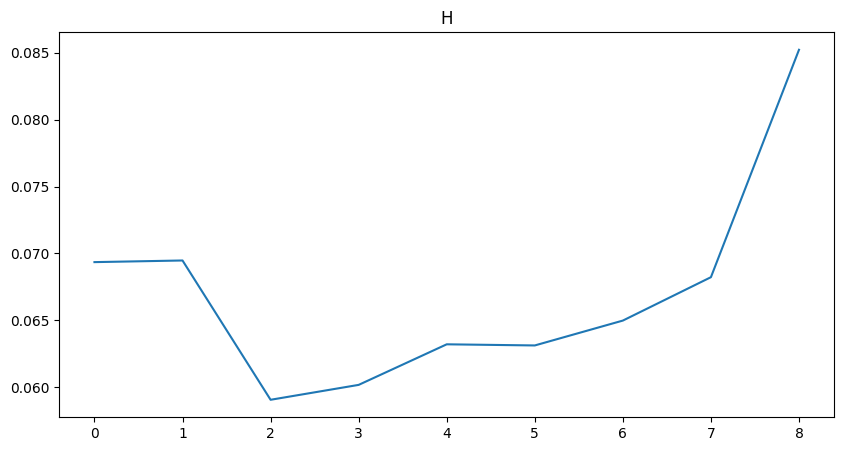

In [6]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(rB_param[:,0])
plt.title("H")

Text(0.5, 1.0, 'Eta')

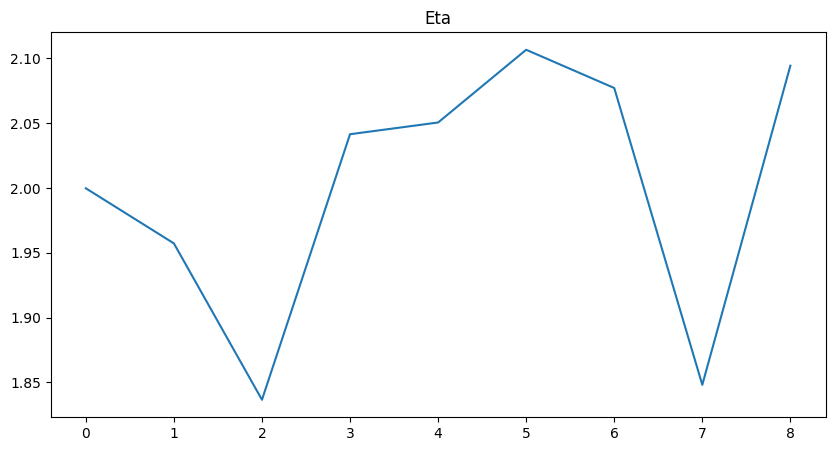

In [7]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(rB_param[:,1])
plt.title("Eta")

Text(0.5, 1.0, 'Rho')

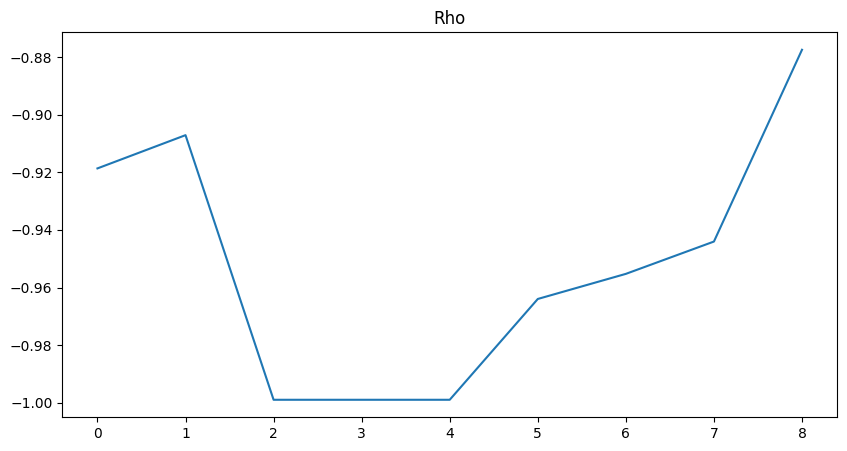

In [8]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(rB_param[:,2])
plt.title("Rho")

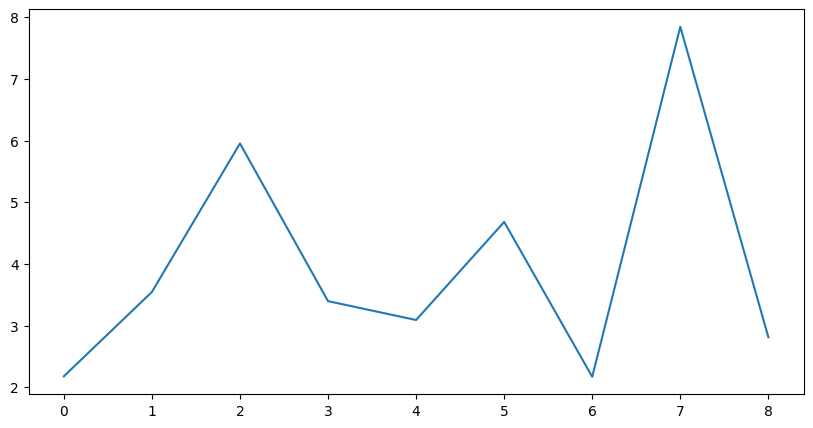

In [9]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(rB_err)

In [10]:
df = pd.DataFrame(rB_param, columns = ["H", "eta", "rho"])
df.to_csv("rB_stability_parameters.csv", index = False)